<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Aula 2 - Abordando Séries Temporais**

## ➥ Motivação Física
---
É muito comum nos depararmos com problemas de evolução temporal de algo na física, como por exemplo, o movimento de uma partícula, ou a variação da temperatura de um objeto. Por isso, é importante termos ferramentas para tratar esses problemas. Como vimos na aula anterior, com o oscilador harmônico, o modelo de camadas densas não foi muito bom para modelar aquele problema. Porém, o problema em si foi mal formulado, queríamos que a rede neural conseguisse prever a posição do oscilador daqui a 20 segundos só fornecendo os dados de posição inicial e velocidade. É uma tarefa muito difícil, tome por exemplo um goleiro, ele não preve onde a bola vai chegar no gol somente a partir do chute inicial, ele constantemente analisa a trajetória da bola para determinar com precisão onde ela vai. Isso pode ser comprovado pela dificuldade de pegar um pênalti, a quantidade de informação para o goleiro analisar é muito menor do que um chute à distância.

Por essa razão, modelamos problemas de séries temporais alimentando o modelo com N intervalos de tempo e pedimos para ele prever os próximos M intervalos de tempo. Vamos verificar essa abordagem novamente com o oscilador harmônico:

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten

In [17]:
def criar_sequencias(X, N_intervalos):
    sequencias_entrada = []
    sequencias_saida = []
    L = X.shape[0]
    for i in range(L-N_intervalos):
        entrada = X[i:i+N_intervalos,:]
        saida = X[i+N_intervalos:i+N_intervalos+1,:]
        sequencias_entrada.append(entrada)
        sequencias_saida.append(saida)
    return np.array(sequencias_entrada), np.squeeze(np.array(sequencias_saida),axis=1) # Squeeze para corrigir o shape das saídas para ser (batches,features), sem ele fica (batches,1,features)


In [21]:
# Definir a função para resolver com ode int
def oscilador_harmonico(y,t,k,m):
    x = y[0]
    v = y[1]
    dvdt = -k/m*x
    return [v,dvdt]
N_intervalos=10

# Fixar semente para obter mesmos resultados
np.random.seed(42)
condicoes_iniciais = [2.4,0.5]
dt = 0.1
t = np.arange(0,10+dt,dt)
k = 0.5
m = 1.0
solucao = odeint(oscilador_harmonico, condicoes_iniciais, t, args=(k,m))
solucao[:,1] = solucao[:,1]*m #momentos

#Criar sequencias com o total de dados

entradas_totais,saidas_totais = criar_sequencias(solucao,10)

#Pegar somente 45 dessas sequencias para treinar o modelo, aproximadamente 50% dos dados, assim como anteriormente

indices = np.arange(0,len(saidas_totais)) #Note que para séries temporais, as entradas têm shape (tamanho_do_batch,N_intervalos,features), nesse caso (45,10,2)
indices = np.random.choice(indices,45,replace=False) # Escolher 45 aleatorios, sem ser iguais (replace=False)
entradas_treinamento, saidas_treinamento = entradas_totais[indices],saidas_totais[indices]

In [60]:
modelo = Sequential([Input((10,2)),
                     Flatten(),
                     Dense(32,activation="tanh"),
                     Dense(32,activation="tanh"),
                     Dense(2,activation="linear")])
modelo.summary()
modelo.compile(optimizer="adam",loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,794 (7.01 KB)

 Trainable params: 1,794 (7.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historico = modelo.fit(entradas_treinamento,saidas_treinamento,epochs=500, batch_size=25,verbose=0)

Agora com o modelo treinado, vamos prever iterativamente a partir das primeiras 10 posições. O modo que estou fazendo abaixo é meio confuso mas basicamente é só usar o modelo prever a posição após as 10 posições iniciais, fazer um novo vetor com as 9 posições antigas, tirando o mais antigo, nesse caso, a primeira posição e adicionando a previsão anterior para fazer uma nova previsão e assim sucetivamente.   

In [7]:
previsoes = entradas_totais[0,:,:].tolist() # Transforma as primeiras posicoes em uma lista de posicoes
#Alimentar a rede neural iterativamente a partir da posicao inicial por 190 iterações de dt=0.1s, ou seja, 19s (A entrada cobre o primeiro 1s)
for i in range(190):
    previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,2)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
    previsoes.append(previsao_i.numpy().tolist()[0])

previsoes = np.array(previsoes)


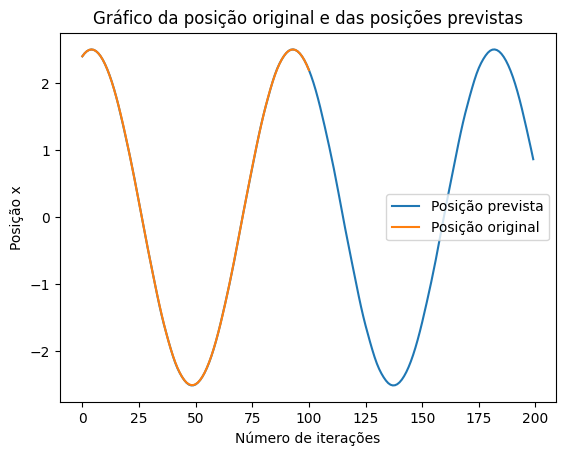

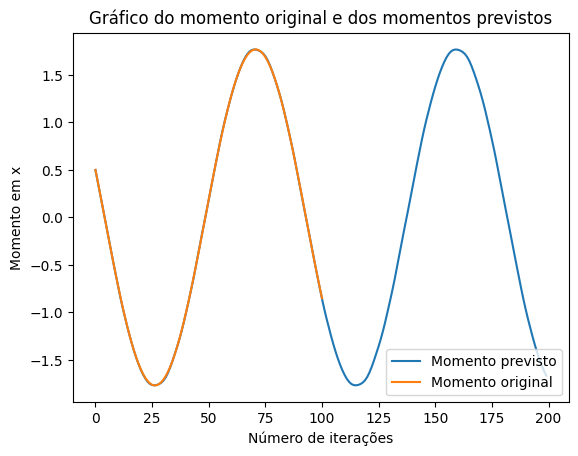

In [14]:
plt.plot(previsoes[:,0], label = "Posição prevista")
plt.plot(solucao[:,0], label="Posição original")
plt.title("Gráfico da posição original e das posições previstas")
plt.ylabel("Posição x")
plt.xlabel("Número de iterações")
plt.legend()
plt.show()

plt.plot(previsoes[:,1], label = "Momento previsto")
plt.plot(solucao[:,1], label = "Momento original")
plt.title("Gráfico do momento original e dos momentos previstos")
plt.ylabel("Momento em x")
plt.xlabel("Número de iterações")
plt.legend()
plt.show()

O resultado é muito melhor! Contudo, para problemas com dependências temporais mais complexas, precisamos incorporar no nosso modelo um mecanismo de memória e que entenda que os dados estão organizados de forma que o passo t dependa do passo t-1. Para isso, temos as **redes neurais recorrentes**. 

## **➥ Redes Neurais Recorrentes** 

Quando tratamos o problema anterior, usamos redes densamente conectadas em que cada passo temporal era considerada uma *feature*, ou característica diferente para o modelo, não existia nenhuma noção de causalidade, pois as operações matemáticas realizadas para o passo 0 eram quase totalmente disconexas das do passo 1. A única conexão entre elas era combinada com um emaranhado de conexões de todas as outras. Isso obviamente não reflete muito bem a noção de causa-consequência embutida em séries temporais. Para isso, as redes neurais recorrentes (RNNs) foram criadas. A lógica delas é que para obter a previsão final, são realizados cálculos em sequência conforme a ordem da série temporal. Novamente, acredito ser mais fácil ver a estrutura do que explicar com palavras. Vamos fazer uma rede recorrente simples, com 1 neurônio para o caso acima, porém mais simplificado, com entradas de 3 intervalos da posição e momento:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/RNN.png" alt="RNN" width="600">
</div>

Vamos lá, na parte mais à esquerda, começamos multiplicando o vetor $\textbf{x}_{0}$ = $(x_0,p_0)^T$ pela matriz de pesos $\textbf{W}_x$, que tem dimensão $\mathbb{R}^{n_{x} \times n_{neuronios}}$, onde nesse caso $n_{x} = 2$, então, somamos à ele o vetor 0, pois não há nenhum passo de tempo antes de $\textbf{x}_{0}$ e adicionamos o vetor coluna de viés $\textbf{b}$, de dimensão $\mathbb{R}^{n_{neuronios}}$, aplicando a função de ativação $\phi$, temos como resultado um vetor coluna $\textbf{y}_{0}$, de dimensão $\mathbb{R}^{n_{neuronios}}$. Em seguida, prosseguimos para o tempo 1 e fazemos a multiplicação do vetor $\textbf{x}_{1}$ pela matriz de pesos $\textbf{W}_x$, porém dessa vez, adicionamos o vetor coluna resultante de $\textbf{W}_{y} \textbf{y}_0$ e o vetor de viéses, e por fim, aplicamos a função de ativação. Fazemos isso para o próximo passo, chegando ao nosso resultado final $\textbf{y}_2$. Com isso, temos uma sequência bem definida de causalidade, já que a saída da célula do tempo t é afetada diretamente pela célula do tempo t-1. 

Note que, apesar do tensorflow retornar automaticamente somente a saída final, é possível retornar todas as sequências e obter saída de formato (n_batches,n_tempos,n_neuronios).

Essa é a rede neural recorrente mais simples possível, em que passamos para a célula do tempo t a saída $\textbf{y}_{t-1}$, porém as redes recorrentes mais sofisticadas e que performam melhor passam um estado $\textbf{h}_{t-1} \neq \textbf{y}_{t-1}$ que também é função do tempo passado diretamente, mas com mecanismos mais complicados. Por exemplo, nas RNNs simples profundas, que possuem camadas de RNNs uma em cima da outra, o estado $\textbf{h}_{t-1}^{l-1}$ é passado tanto para $\textbf{h}_{t}^{l-1}$ quanto para $\textbf{h}_{t-1}^{l}$, como é possível observar no diagrama abaixo:

---
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/deep-rnn.svg" 
       alt="RNN" width="600">
</div>

  Arquitetura de uma RNN profunda desenrolada no tempo com L camadas (de Zhang et al., *Dive into Deep Learning*).

Nesse caso, temos que, dado uma entrada $\mathbf{X}_t \in \mathbb{R}^{n \times d}$, onde n é o número de diferentes entradas e d é o número de passos temporais (nesse caso a entrada só tem uma característica, por exemplo a posição). Então o estado da l-ésima camada no tempo t é:

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)} + \mathbf{b}_{h}^{(l)}),$$

Onde $\mathbf{W}_{xh}, \mathbf{W}_{hh}$ são as respectivas matrizes matrizes de pesos. 

E a sequência de saída final de cada tempo t, que na nossa notação seria $\textbf{y}_{t}$, mas nesse caso é $\textbf{O}_{t}$ é:

$$\mathbf{O}_{t} = \mathbf{H}_{t}^{(L)}\mathbf{W}_{hq} + \mathbf{b}$$

### Referências

1. Zhang, Mu, et al. “Dive into Deep Learning.” *Dive into Deep Learning*, CC BY-SA 4.0, https://d2l.ai  
2. CC BY-SA 4.0 texto de licença: https://creativecommons.org/licenses/by-sa/4.0/
---

Em todos os exemplos posteriores ao próximo, usaremos uma dessas alternativas que é a LSTM, a rede de memória curta de longo prazo, que resolve o problema que as redes neurais recorrentes simples têm de possuir uma memória relativamente curta. Por exemplo, se sua entrada tiver 50 pontos temporais, o efeito que o primeiro tempo tem em uma RNN simples fica muito pequeno após tantos passos temporais e tende a desaparecer. A LSTM utiliza mecanismos de esquecimento e lembrança deliberados, ou seja, a rede neural escolhe o que lembra e o que esquece, através de portas. Com isso, ela consegue reter informações mais antigas que podem ser essenciais para problemas mais complexos. Explicarei melhor o funcionamento após desse exemplo.

Vamos aplicar uma RNN simples profunda para um problema mais complexo, o lançamento balístico com atrito, cuja equação de movimento é:

\begin{equation*}
\begin{cases}
\frac{d\mathbf{r}}{dt} = \mathbf{v} \\
\frac{d\mathbf{v}}{dt} = -\mathbf{g} - \frac{1}{2m} \rho C_D A \|\mathbf{v}\| \, \mathbf{v}
\end{cases}
\end{equation*}

Com o vetor coluna $\mathbf{v} = (v_x,v_y)^T$; vetor coluna $\mathbf{g} = (0,g)^T$; $\rho$, $C_D$, $A$, m sendo respectivamente a densidade do ar, o coeficiente de arrasto, a área transversal do objeto e a massa do objeto. Para isso, vamos normalizar a trajetória inteira com o MinMaxScaler para que as posições fiquem entre [-1,1]. É comum realizar essas normalizações nos dados do modelo para facilitar o aprendizado.


In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import newton
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
#xy0 é [x0,y0] vxy0 é [vx0, vy0]
def lancamento_balistico(g, mu, xy0, vxy0, tt):
    def dif(vec, t):
        # derivada de vec = [x, y, vx, vy]
        v = np.sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec  # retorna x, y, vx, vy

#Função para pegar a trajetória até o ponto em que o projétil encosta no chão de novo
def fazer_trajetoria(g,mu,xy0,vxy0,dt):
    t_pico = newton(lambda t: lancamento_balistico(g, mu, xy0, vxy0, [0, t])[1,3], 0) # Usa o método de Newton para achar o tempo em que v_y é 0, ou seja y é máximo, com o chute inicial de t=0
    t_chao = newton(lambda t: lancamento_balistico(g, mu, xy0, vxy0, [0, t])[1,1], 2 * t_pico) # Usa o método de Newton para achar o tempo em que y é 0, com o chute inicial de t=2*t_pico
    t_array = np.arange(0,t_chao,dt)
    trajetoria = lancamento_balistico(g, mu, xy0, vxy0, t_array)
    return trajetoria

def criar_sequencias(X, N_intervalos):
    sequencias_entrada = []
    sequencias_saida = []
    L = X.shape[0]
    for i in range(L-N_intervalos):
        entrada = X[i:i+N_intervalos,:]
        saida = X[i+N_intervalos:i+N_intervalos+1,:]
        sequencias_entrada.append(entrada)
        sequencias_saida.append(saida)
    return np.array(sequencias_entrada), np.squeeze(np.array(sequencias_saida),axis=1) # Squeeze para corrigir o shape das saídas para ser (batches,features), sem ele fica (batches,1,features)



# Parâmetros do projétil (modelado para uma bola de futebol)
g       = 9.81         # Aceleração da gravidade (m/s^2)
rho_ar = 1.29         # Densidade do ar(kg/m^3)
m       = 0.430        # Massa da bola (kg)
cD      = 0.47          # Coeficiente de arrasto (projétil esférico)
r       = 0.11       # Raio da bola (m)
mu = 0.5 * cD * (np.pi * r ** 2) * rho_ar / m

v0 = 55.2     # Velocidade inicial (m/s)
theta0 = np.deg2rad(57.2) # Ângulo inicial (rad)
x0 = [0.0,0.0] # Posições iniciais
v0_compontentes = [v0*np.cos(theta0),v0*np.sin(theta0)] # Velocidades iniciais
dt = 0.01
solucao = fazer_trajetoria(g,mu,x0,v0_compontentes,dt)[:,:2] # Pegar só as posições (x,y)
scaler = MinMaxScaler((-1,1))
solucao = scaler.fit_transform(solucao)

In [4]:
N_intervalos = 10
entradas_totais,saidas_totais = criar_sequencias(solucao,N_intervalos)
np.random.seed(42)

#Pegar somente 50 dessas sequencias para treinar o modelo, aproximadamente 25% dos dados, assim como anteriormente
indices = np.arange(0,len(saidas_totais)) #Note que para séries temporais, as entradas têm shape (tamanho_do_batch,N_intervalos,features), nesse caso (50,10,4)
indices = np.random.choice(indices,100,replace=False) # Escolher 45 aleatorios, sem ser iguais (replace=False)
indices_treinamento = indices[:50]
indices_validacao = indices[50:75]
indices_teste = indices[75:]
entradas_treinamento, saidas_treinamento = entradas_totais[indices_treinamento],saidas_totais[indices_treinamento]
entradas_validacao, saidas_validacao = entradas_totais[indices_validacao],saidas_totais[indices_validacao]
entradas_teste, saidas_teste = entradas_totais[indices_teste],saidas_totais[indices_teste]


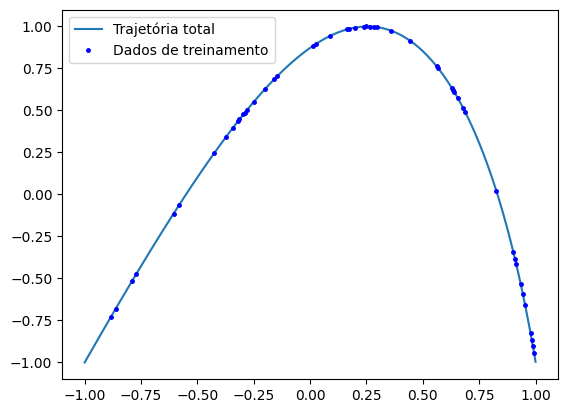

In [5]:
plt.plot(solucao[:,0],solucao[:,1],label="Trajetória total")
plt.plot(saidas_treinamento[:,0],saidas_treinamento[:,1],"bo",markersize=2.5,label="Dados de treinamento")
plt.legend()
plt.show()

In [ ]:
modelo = Sequential([Input((N_intervalos,2)),
                     SimpleRNN(20,return_sequences=True),
                     SimpleRNN(20,return_sequences=False),
                     Dense(2,activation="linear")
                     ])
modelo.compile(optimizer=Adam(learning_rate=1e-4),loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)
modelo.summary()

In [ ]:
modelo_ja_treinado = True # Variavel para decidir se vai carregar um modelo já treinado ou treinar o modelo
if modelo_ja_treinado == True:
    modelo.load_weights('/modelos/Modelo_RNN_simples_1.weights.h5') # Mude para o diretorio correto caso necessário
else:
    early_stopping = EarlyStopping(monitor="val_loss",patience=100)
    historico = modelo.fit(entradas_treinamento,saidas_treinamento,validation_data=(entradas_validacao,saidas_validacao),epochs=5000, batch_size=10,verbose=2)

In [8]:
def previsao(dado_inicial,modelo):
    previsoes = dado_inicial.tolist() # Transforma as primeiras posicoes em uma lista de posicoes
    #Alimentar a rede neural iterativamente a partir da posicao inicial por 190 iterações de dt=0.1s, ou seja, 19s (A entrada cobre o primeiro 1s)
    i=0
    while True:
        previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,2)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
        if previsao_i[0][1]<-1.0 or i>1000:
            break
        previsoes.append(previsao_i.numpy().tolist()[0])
        i+=1

    previsoes = np.array(previsoes)
    return previsoes


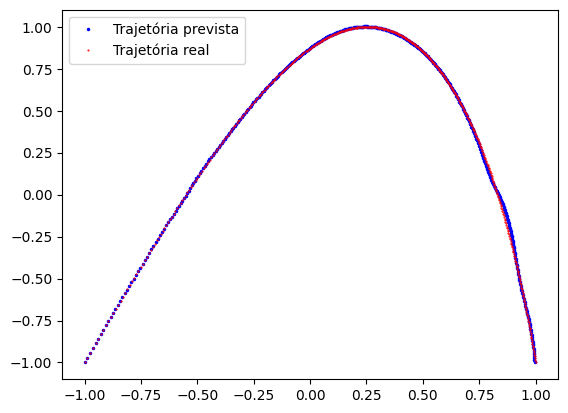

In [9]:
previsoes = previsao(entradas_totais[0,:,:],modelo)
plt.plot(previsoes[:,0],previsoes[:,1],"bo",markersize=1.5,label="Trajetória prevista")
plt.plot(solucao[:,0],solucao[:,1],"ro",markersize=0.5,label="Trajetória real")
plt.legend()
plt.show()

Note que a previsão iterativa do modelo não ficou perfeita. Embora seja possível atenuar esse erro com treinamento mais longo e ajustes nas taxas de aprendizado, ainda reflete uma limitação das RNNs simples. O mecanismo de memória dessas redes é muito simples para capturar as mudanças complexas na posição ao longo do tempo—especialmente quando há resistência do ar. Por isso, para problemas de séries temporais mais desafiadores, recomenda‑se o uso de variantes com memória aprimorada, como LSTMs ou GRUs. Vamos apresentar agora as LSTMs:

## **➥ LSTMs**

As LSTMs possuem uma arquitetura muito mais sofisticada, imagine uma RNN simples que, como padrão, recebe o estado anterior $\mathbf{h_{t-1}}$ e a entrada do tempo t $\mathbf{x_{t}}$, porém, também recebe uma nova sequência, $\mathbf{c_{t-1}}$, que denominaremos de estado de longo prazo. Com isso, ela processa a saída $\mathbf{g_{t}}$ através da multiplicação pelos pesos, adicionando o viés e aplicando a função de ativação tanh da mesma forma que anteriormente, sem o uso do estado de longo prazo. Até agora, nada de novo, o pulo do gato é, introduzimos 3 mecanismos para servir como portas que controlam o quanto da informação passa. Podemos pensar neles também como potenciometros, que ao girarmos, deixamos passar mais ou menos da "corrente de informação".

$\hspace{10px}\bullet$ A primeira porta é a porta de esquecimento, ela determina quais partes do estado de longo prazo devem ser deletados a partir do novo contexto adquirido por $\mathbf{g_{t}}$. Por exemplo, suponha que na minha memória de longo prazo eu tivesse a impressão que um movimento fosse constante, mas com o contexto novo adquirido por $\mathbf{g_{t}}$, eu entendesse que na verdade ele só varia pouco. Então eu esqueço a noção anterior que estava no estado de longo prazo sobre o movimento ser constante.

$\hspace{10px}\bullet$ A segunda porta é a porta de entrada, ela determina quais partes do contexto adquirido por $\mathbf{g_{t}}$ devem entrar no estado de longo prazo. Seguindo o exemplo, ela determinaria a incorporação da noção que o movimento em questão varia pouco no estado de longo prazo.

$\hspace{10px}\bullet$ A terceira porta e ultima porta é a porta de saída, ela controla quais partes do estado de longo prazo que devem ser consideradas para fazer o novo estado de saída da célula $\mathbf{h_{t}}$ e a saída da célula $\mathbf{y_{t}}$, que pode ser diferente de $\mathbf{h_{t}}$ em geral. Ela é a porta que controla o que vai para as saídas da célula e essas saídas são como a memória de curto prazo da rede. Então, seguindo o exemplo, vamos supor que no tempo t a rede note uma pequena perturbação no movimento, essa porta então decide enviar essa informação para a memória de curto prazo, que, caso seja relevante, possivelmente entre na de longo prazo nos tempos futuros.

Todas essas portas passam pela função de ativação logística, que é uma função limitada à imagem (0,1). Por isso que elas são portas que controlam o fluxo de informação, pois tanto o estado de longo prazo quando a saída $\mathbf{g_{t}}$ são multiplicados diretamente (termo a termo do vetor) pelos vários fatores de 0 a 1. 

O tratamento dado aqui não foi muito matemático, o objetivo é entender a lógica por trás para não ser uma caixa preta total. Para um tratamento matemático, recomendo o livro online "Dive Into Deep Learning", de Zhang et al., especificamente https://d2l.ai/chapter_recurrent-modern/lstm.html, ou o livro em português, "Mãos à Obra: Aprendizado de Máquina com Scikit-Learn, Keras & TensorFlow: Conceitos, Ferramentas e Técnicas Para a Construção de Sistemas Inteligentes", de Aurélien Géron, ou mesmo o artigo original de Hochreiter e Schmidhuber, "Long Short-Term Memory".

Vamos testar a eficácia dessa rede no mesmo exemplo do lançamento balístico, caso não tenha rodado as células anteriores, rode-as até a definição do modelo:

In [6]:
from tensorflow.keras.layers import LSTM

In [8]:
modelo = Sequential([Input((N_intervalos,2)),
                     LSTM(20,return_sequences=True),
                     LSTM(20,return_sequences=False),
                     Dense(2,activation="linear")
                     ])
modelo.compile(optimizer=Adam(learning_rate=1e-4),loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 20)         │         1,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,162 (20.16 KB)

 Trainable params: 5,162 (20.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo_ja_treinado = True # Variavel para decidir se vai carregar um modelo já treinado ou treinar o modelo
if modelo_ja_treinado == True:
    modelo.load_weights('/modelos/Modelo_LSTM_1.weights.h5') # Mude para o diretorio correto caso necessário
else:
    early_stopping = EarlyStopping(monitor="val_loss",patience=100)
    historico = modelo.fit(entradas_treinamento,saidas_treinamento,validation_data=(entradas_validacao,saidas_validacao),epochs=5000, batch_size=10,verbose=2)

In [10]:
def previsao(dado_inicial,modelo):
    previsoes = dado_inicial.tolist() # Transforma as primeiras posicoes em uma lista de posicoes
    #Alimentar a rede neural iterativamente a partir da posicao inicial por 190 iterações de dt=0.1s, ou seja, 19s (A entrada cobre o primeiro 1s)
    i=0
    while True:
        previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,2)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
        if previsao_i[0][1]<-1.0 or i>1000:
            break
        previsoes.append(previsao_i.numpy().tolist()[0])
        i+=1

    previsoes = np.array(previsoes)
    return previsoes


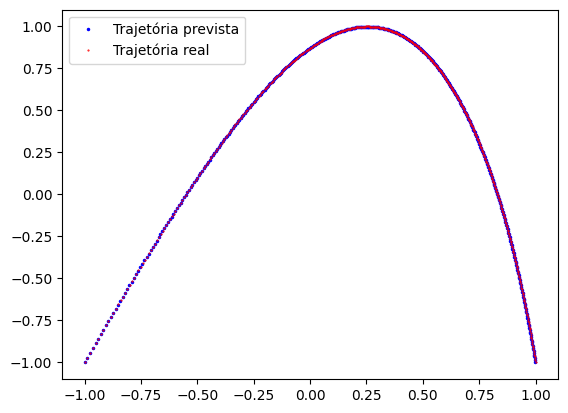

In [28]:
previsoes = previsao(entradas_totais[0,:,:],modelo)
plt.plot(previsoes[:,0],previsoes[:,1],"bo",markersize=1.5,label="Trajetória prevista")
plt.plot(solucao[:,0],solucao[:,1],"ro",markersize=0.5,label="Trajetória real")
plt.legend()
plt.show()

Como é possível observar, a previsão ficou muito melhor. Até agora só vimos se conseguimos fazer uma rede neural aprender uma trajetória, vamos testar as capacidades de generalização para múltiplas condições iniciais nos próximos notebooks de exemplo. 